[View in Colaboratory](https://colab.research.google.com/github/XinyueZ/tf/blob/master/ipynb/price_rooms_estimator_clean_data.ipynb)

# This case is a ML model about the linear relationship between "average housing area" and "price per housing area".

In [0]:
import tensorflow as tf
from tensorflow.python.data import Dataset
import sklearn
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [0]:
STEPS = 1000  # Steps of train loop. 
PERIODS = 20
STEPS_PER_PERIOD = STEPS / PERIODS
LEARNING_RATE = 0.000001
BINS = 150

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [292]:
source = pd.read_csv("https://dl.dropbox.com/s/e2tcsgbcp2in5h5/price_rooms_area.tsv", sep="\t")
source.head()

,PRICE,ROOMS,AREA,OBJECTCAT,MARKETINGTYPE
0,5,0,249,Sonstiges Büro-/Praxisobjekt,Miete
1,595000,9,440,Besondere Immobilie,Kauf
2,199000,6,"135,75",Stadthaus,Kauf
3,269000,9,"203,57",Stadthaus,Kauf
4,562,3,"63,15",Etagenwohnung,Miete


# Clean the data-source
- Remove rows containing *null*
- Remove rows containing *N/A*
- Add New data columns: "Average housing area" and "per housing area price".
- Clean new added columns

In [0]:
def clean_data(source):
  df = source
  
  # Remove null rows
  df = df[pd.notnull(df["PRICE"])]
  df = df[pd.notnull(df["ROOMS"])]
  df = df[pd.notnull(df["AREA"])]
  
  # Remove useless columns
  df = df.drop(["OBJECTCAT"], axis=1)
  df = df[~df["MARKETINGTYPE"].isin(["Miete"])]
  df = df.drop(["MARKETINGTYPE"], axis=1)
  
  # Convert all strings to numeric
  df = df.convert_objects(convert_numeric=True)
  
  # Remove rows containing a "0", i.e price = 0 or rooms = 0
  df = df[~(df[["PRICE", "ROOMS","AREA"]] == 0)]
  
  # Remove rows containing N/A 
  df = df[pd.notna(df["PRICE"])]
  df = df[pd.notna(df["ROOMS"])]
  df = df[pd.notna(df["AREA"])]

  # Insert new column of "price of pro-area"
  df.insert(1, "PRICE_PRO_AREA", df["PRICE"] / df["AREA"]) 
  df = df[~(df["PRICE_PRO_AREA"] < 5)]
  #df["PRICE_PRO_AREA"] = df["PRICE_PRO_AREA"] / 1000 #Scale -1000 for easy demo.
  df["PRICE_PRO_AREA"] = np.log(df["PRICE_PRO_AREA"])
  df = df[pd.notnull(df["PRICE_PRO_AREA"])]
  df = df[pd.notna(df["PRICE_PRO_AREA"])]
    
  # Insert new column of "area of each room"
  df.insert(4, "AREA_PRO_ROOM", df["AREA"] / df["ROOMS"]) 
  df = df[~(df["AREA_PRO_ROOM"] < 1)]
  df["AREA_PRO_ROOM"] = np.log(df["AREA_PRO_ROOM"])
  df = df[pd.notnull(df["AREA_PRO_ROOM"])]
  df = df[pd.notna(df["AREA_PRO_ROOM"])]
  
  return df

In [294]:
df = clean_data(source)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [295]:
df.head()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM
1,595000.0,7.209542,9.0,440.0,3.889550
5,299000.0,7.666556,5.0,140.0,3.332205
6,685000.0,7.497003,8.0,380.0,3.860730
8,206000.0,6.600842,1.0,280.0,5.634790
9,75000.0,7.114370,3.0,61.0,3.012262


In [296]:
df.describe()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM
count,1.281800e+05,128180.000000,128180.000000,128180.000000,128180.000000
mean,1.054886e+06,7.524109,5.187603,183.766251,3.452136
std,2.231478e+08,0.733975,5.268999,556.929503,0.426526
min,3.000000e+02,1.629641,1.000000,1.000000,0.000000
25%,1.390000e+05,7.130899,3.000000,87.000000,3.218876
50%,2.500000e+05,7.561682,4.000000,130.000000,3.394508
75%,4.250000e+05,7.963808,6.000000,200.000000,3.604138
max,7.987979e+10,20.960654,540.000000,84000.000000,9.903488


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f760c730a58>]],
      dtype=object)

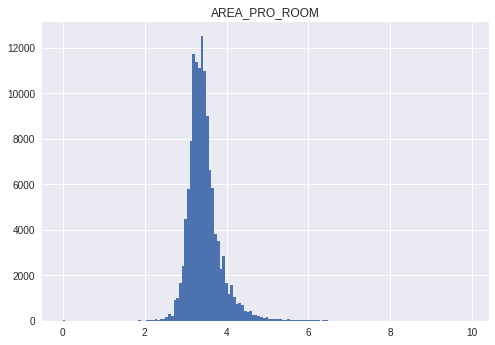

In [297]:
df.hist("AREA_PRO_ROOM", bins=BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f760e864668>]],
      dtype=object)

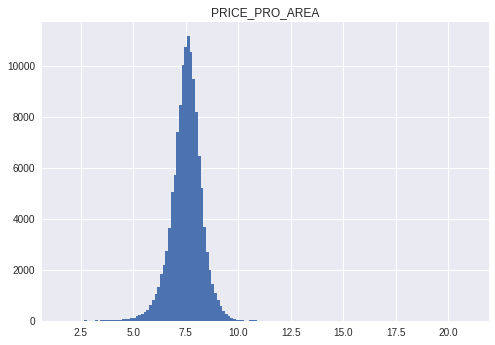

In [298]:
df.hist("PRICE_PRO_AREA", bins=BINS)

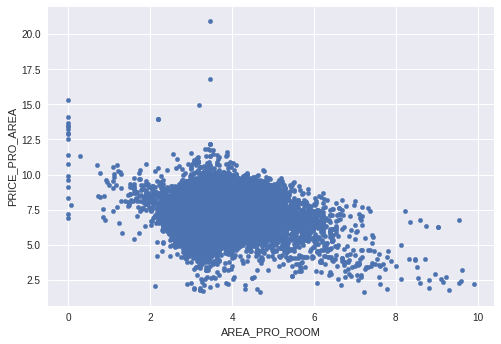

In [299]:
df.plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [0]:
def make_dataset_and_labels_and_class_num(df, label_name):
  """This method will prepare da, labels for train, evaluation, test.
     Args:
      df: DataFrame format of datasource.
      label_name: The name of column in datasource which will be as target for train.
     Return: 
       Tuple of (ds_train, ds_eval, ds_test, label_train, label_eval, label_test)
      
  """
  target_label_col = label_name
   
  random_seed = None
  np.random.seed(random_seed)
  
  ds_train = df.sample(frac=0.7, random_state=random_seed)
  label_train = ds_train[[target_label_col]]
  
  ds_rest = df.drop(ds_train.index)
  ds_rest = ds_rest.copy()
  
  ds_eval = ds_rest.sample(frac=0.7, random_state=random_seed)
  label_eval = ds_eval[[target_label_col]]
  
  ds_test = ds_rest.drop(ds_eval.index)
  label_test = ds_test[[target_label_col]]
  
  return ds_train[["AREA_PRO_ROOM"]], ds_eval[["AREA_PRO_ROOM"]], ds_test[["AREA_PRO_ROOM"]], label_train, label_eval, label_test

In [0]:
x_train, x_eval, x_test, y_train, y_eval, y_test = make_dataset_and_labels_and_class_num(df, "PRICE_PRO_AREA")

In [302]:
x_train.describe()

,AREA_PRO_ROOM
count,89726.000000
mean,3.450664
std,0.421591
min,0.000000
25%,3.218876
50%,3.392829
75%,3.601868
max,9.581904


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f760ea6a2e8>]],
      dtype=object)

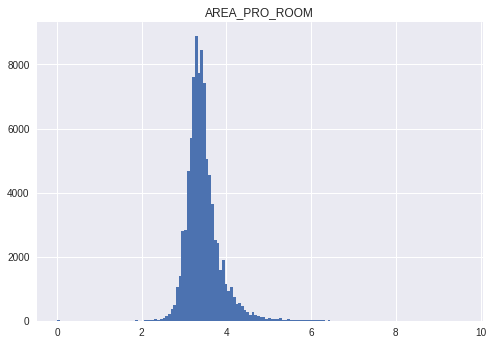

In [303]:
x_train.hist("AREA_PRO_ROOM", bins = BINS)

In [304]:
y_train.describe()

,PRICE_PRO_AREA
count,89726.000000
mean,7.522862
std,0.734946
min,1.629641
25%,7.130899
50%,7.561424
75%,7.962764
max,20.960654


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7618206c88>]],
      dtype=object)

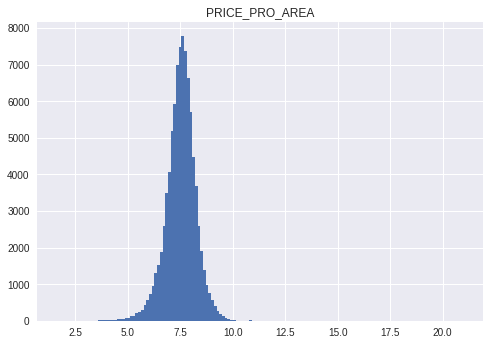

In [305]:
y_train.hist("PRICE_PRO_AREA", bins=BINS)

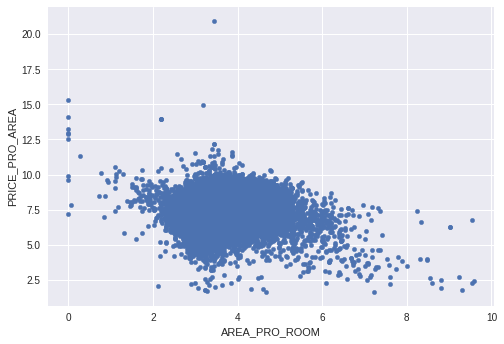

In [306]:
pd.concat([x_train, y_train], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA') 

In [307]:
x_eval.describe()

,AREA_PRO_ROOM
count,26918.000000
mean,3.456192
std,0.433858
min,0.000000
25%,3.218876
50%,3.401197
75%,3.610918
max,9.903488


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f760c745cf8>]],
      dtype=object)

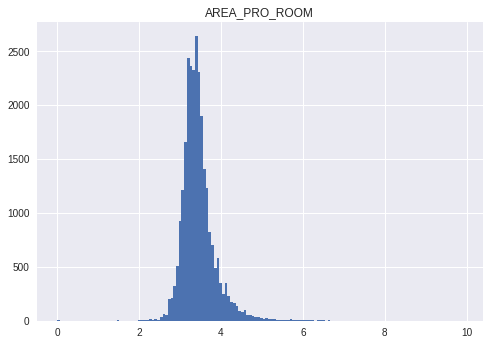

In [308]:
x_eval.hist("AREA_PRO_ROOM", bins = BINS)

In [309]:
y_eval.describe()

,PRICE_PRO_AREA
count,26918.000000
mean,7.526831
std,0.730836
min,1.832581
25%,7.130899
50%,7.563440
75%,7.962983
max,16.762453


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f761387da20>]],
      dtype=object)

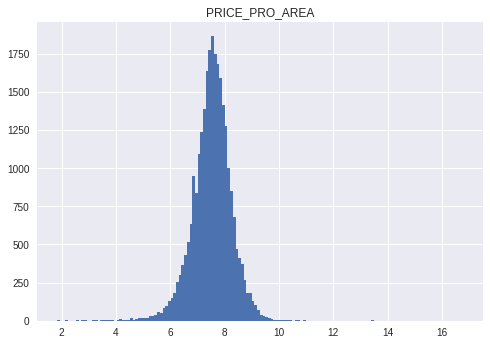

In [310]:
y_eval.hist("PRICE_PRO_AREA", bins=BINS)

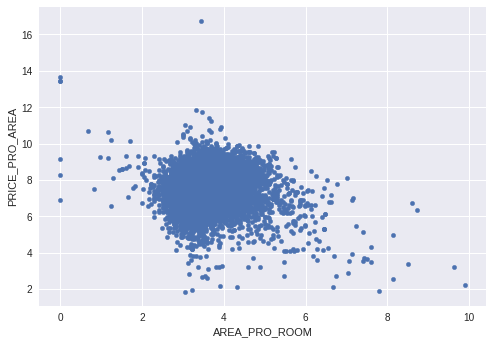

In [311]:
pd.concat([x_eval, y_eval], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [312]:
x_test.describe()

,AREA_PRO_ROOM
count,11536.000000
mean,3.454119
std,0.446919
min,0.000000
25%,3.218876
50%,3.392829
75%,3.604138
max,9.164820


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f760d3e0e48>]],
      dtype=object)

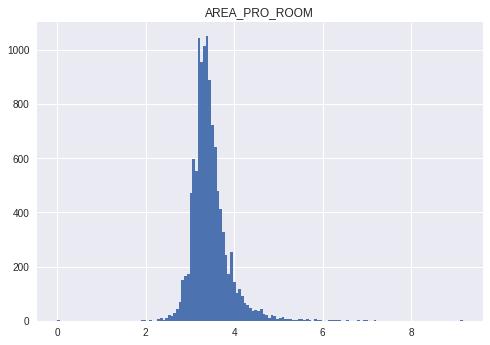

In [313]:
x_test.hist("AREA_PRO_ROOM", bins=BINS)

In [314]:
y_test.describe()

,PRICE_PRO_AREA
count,11536.000000
mean,7.527463
std,0.733756
min,2.377664
25%,7.132757
50%,7.566605
75%,7.973929
max,12.157282


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7615e31898>]],
      dtype=object)

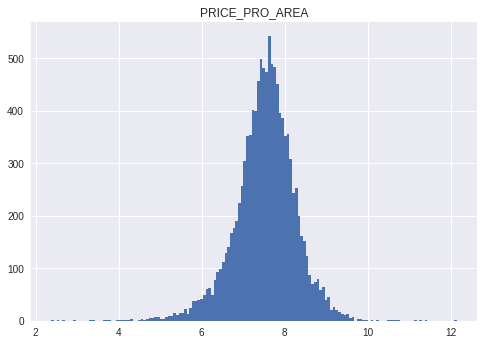

In [315]:
y_test.hist("PRICE_PRO_AREA", bins=BINS)

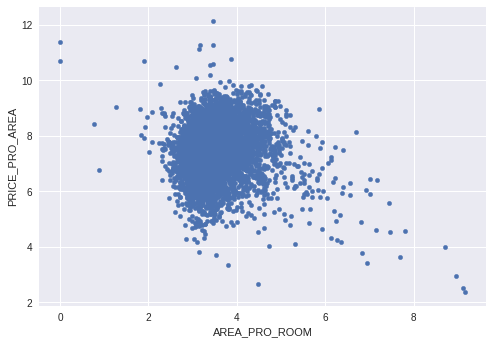

In [316]:
pd.concat([x_test, y_test], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [317]:
x_train.head()

,AREA_PRO_ROOM
232574,3.496508
278579,3.449988
8266,2.944439
194947,3.258097
84435,2.813411


In [318]:
x_eval.head()

,AREA_PRO_ROOM
147065,3.784190
49169,3.316204
92310,3.242592
201635,4.287411
141812,3.538057


In [319]:
x_test.head()

,AREA_PRO_ROOM
8,5.634790
30,3.941582
44,3.967593
105,2.944439
126,3.264486


In [320]:
y_train.head()

,PRICE_PRO_AREA
232574,8.255435
278579,8.111490
8266,7.444556
194947,7.605699
84435,7.740664


In [321]:
y_eval.head()

,PRICE_PRO_AREA
147065,8.557288
49169,6.870790
92310,7.508479
201635,7.470637
141812,7.496833


In [322]:
y_test.head()

,PRICE_PRO_AREA
8,6.600842
30,8.816938
44,8.202112
105,6.017440
126,6.220957


In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
 
    # Construct a dataset, and configure batching/repeating
    features = {key:np.array(value) for key,value in dict(features).items()} 
  
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
train_input_fn = lambda: input_fn(x_train, y_train)

In [0]:
train_predict_input_fn = lambda: input_fn(x_train, y_train, num_epochs=1, shuffle=False)

In [0]:
eval_predict_input_fn = lambda: input_fn(x_eval, y_eval, num_epochs=1, shuffle=False)

In [0]:
test_predict_input_fun = lambda: input_fn(x_test, y_test, num_epochs=1, shuffle=False)

In [0]:
feature_cols = [
  tf.feature_column.numeric_column("AREA_PRO_ROOM") 
]

In [0]:
train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_optimizer = tf.contrib.estimator.clip_gradients_by_norm(train_optimizer, 5.0)

In [330]:
model = tf.estimator.LinearRegressor(
    feature_columns = feature_cols,
    optimizer = train_optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4q1z3h47', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7617242e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [331]:
for period in range(0, PERIODS):
  model.train(input_fn=train_input_fn, steps=STEPS)
  #train_predict = model.predict(input_fn=train_predict_input_fn)
  #eval_predict = model.predict(input_fn=eval_predict_input_fn)
  print("-" * 100)
  metrics_train = model.evaluate(steps=STEPS, input_fn=train_predict_input_fn)
  metrics_eval = model.evaluate(steps=STEPS, input_fn=eval_predict_input_fn) 
  print("-" * 100)
  
  #train_predict = np.array([item['predictions'][0] for item in train_predict])
  #eval_predict = np.array([item['predictions'][0] for item in eval_predict])
  
  # Compute loss for train and evaluation
  #train_rmse = math.sqrt(
  #      sklearn.metrics.mean_squared_error(train_predict, y_train))
  #eval_rmse = math.sqrt(
  #      sklearn.metrics.mean_squared_error(eval_predict, y_eval))
  train_rmse = np.sqrt(metrics_train['average_loss'])
  eval_rmse = np.sqrt(metrics_eval['average_loss'])
  
  print("*" * 100)
  print("*Period[rmse training] %02d : %0.2f" % (period, train_rmse))
  print("*Period[rmse eval] %02d : %0.2f" % (period, eval_rmse))  
  print("*" * 100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp4q1z3h47/model.ckpt.
INFO:tensorflow:loss = 67.03378, step = 0
INFO:tensorflow:global_step/sec: 327.441
INFO:tensorflow:loss = 67.95565, step = 100 (0.310 sec)
INFO:tensorflow:global_step/sec: 457.422
INFO:tensorflow:loss = 65.66771, step = 200 (0.218 sec)
INFO:tensorflow:global_step/sec: 462.833
INFO:tensorflow:loss = 66.63992, step = 300 (0.217 sec)
INFO:tensorflow:global_step/sec: 467.36
INFO:tensorflow:loss = 53.07357, step = 400 (0.214 sec)
INFO:tensorflow:global_step/sec: 463.148
INFO:tensorflow:loss = 54.84684, step = 500 (0.216 sec)
INFO:tensorflow:global_step/sec: 445.212
INFO:tensorflow:loss = 34.37555, step = 600 (0.222 sec)
INFO:tensorflow:global_step/sec: 408.641
INFO:tensorflow:loss = 7

In [332]:
test_predict = model.predict(input_fn=test_predict_input_fun)
print("-" * 100)
metrics_test = model.evaluate(steps=STEPS, input_fn=test_predict_input_fun)
print("-" * 100)
test_predict = np.array([item['predictions'][0] for item in test_predict])  
#test_rmse = math.sqrt(
#        sklearn.metrics.mean_squared_error(test_predict, y_test))
test_rmse = np.sqrt(metrics_test['average_loss'])
print("*" * 100)
print("*Final[rmse test] %02d : %0.2f" % (period, test_rmse))
print("*" * 100)

----------------------------------------------------------------------------------------------------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-12-22:20:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4q1z3h47/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-08-12-22:20:30
INFO:tensorflow:Saving dict for global step 20000: average_loss = 51.660152, global_step = 20000, label/mean = 7.5073366, loss = 51

In [0]:
test_predict = np.array([item for item in test_predict])

In [334]:
test_predict

array([0.56856644, 0.4061817 , 0.40867627, ..., 0.3216608 , 0.38813612,
       0.3691405 ], dtype=float32)